In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import (
    auprc,
    factor_enrichment_gsea,
    get_gprofiler,
    inhouse_preprocess,
    perturbation_signal_recovery,
    read_aws_csv,
    read_aws_h5ad,
    read_aws_npz,
    read_aws_pickle,
    retrieve_stringdb_neighbors,
)

In [4]:
# read learned parameters
Z = read_aws_csv(
    "s3://pert-spectra/gsfa_checkpoints/inhouse_gsfa_outputs/Z.csv"
).to_numpy()
W = read_aws_csv(
    "s3://pert-spectra/gsfa_checkpoints/inhouse_gsfa_outputs/W.csv"
).to_numpy()
F = read_aws_csv(
    "s3://pert-spectra/gsfa_checkpoints/inhouse_gsfa_outputs/F.csv"
).to_numpy()
beta = read_aws_csv(
    "s3://pert-spectra/gsfa_checkpoints/inhouse_gsfa_outputs/beta.csv"
).to_numpy()
lsfr = read_aws_csv(
    "s3://pert-spectra/gsfa_checkpoints/inhouse_gsfa_outputs/lsfr.csv"
).to_numpy()
# read gene and perturbation information
gene_labels = read_aws_csv("s3://pert-spectra/gsfa_checkpoints/inhouse_top_genes.csv")[
    "x"
].to_numpy()
pert_labels = read_aws_npz("s3://pert-spectra/gsfa_checkpoints/inhouse_G_labels.npz")[
    "arr_0"
]
pert_labels = [x.split("_")[1] for x in pert_labels[:-1]]
pert_labels = pert_labels + ["ctrl"]
# read inputs and preprocessed input
preprocessed_Y = read_aws_npz(
    "s3://pert-spectra/gsfa_checkpoints/inhouse_GSFA_preprocessed.npz"
)["array1"]
G = read_aws_npz("s3://pert-spectra/gsfa_checkpoints/inhouse_GSFA_inputs.npz")["array2"]

In [ ]:
# read in adata of raw data for reference
adata = read_aws_h5ad("path to raw inhouse h5ad")
adata = adata[:, gene_labels - 1]
adata = inhouse_preprocess(adata)

In [6]:
# filter adata to perturbations with at least 50 samples for each treatment
adata.obs["condition"] = adata.obs["condition"].astype(str)
adata.obs["Treatment"] = adata.obs["Treatment"].astype(str)
adata.obs["pert_treat"] = adata.obs["condition"] + "+" + adata.obs["Treatment"]
obs_df = pd.DataFrame(adata.obs["pert_treat"])
category_counts = obs_df["pert_treat"].value_counts()
filtered_categories = category_counts[category_counts >= 50].index
adata = adata[adata.obs["pert_treat"].isin(filtered_categories)]

# Reconstruction

## Spearman Coefficient
- Spearman correlation between predicted and observed expression (on DE genes if available)

In [7]:
# for GSFA, measure reconstruction on training
from scipy.stats import spearmanr

reconstruction = Z @ W.T
# rebuild pert labels
G_labels = []
for row in G:
    pert_idx = np.where(row == 1)[0].tolist()
    perts = [pert_labels[i] for i in pert_idx]
    G_labels.append("+".join(perts))
test_corr_singles = []
test_corr_combos = []

for pert in set(G_labels):
    hold_idx = [i for i, x in enumerate(G_labels) if x == pert]
    if not hold_idx:
        continue
    recon = reconstruction[hold_idx]
    # correlation
    mean_reconstruction = recon.mean(axis=0)
    mean_observed = preprocessed_Y[hold_idx].mean(axis=0)
    if ("+" in pert) and ("ctrl" not in pert):
        test_corr_combos.append(
            [pert, spearmanr(mean_reconstruction, mean_observed)[0]]
        )
    else:
        test_corr_singles.append(
            [pert, spearmanr(mean_reconstruction, mean_observed)[0]]
        )

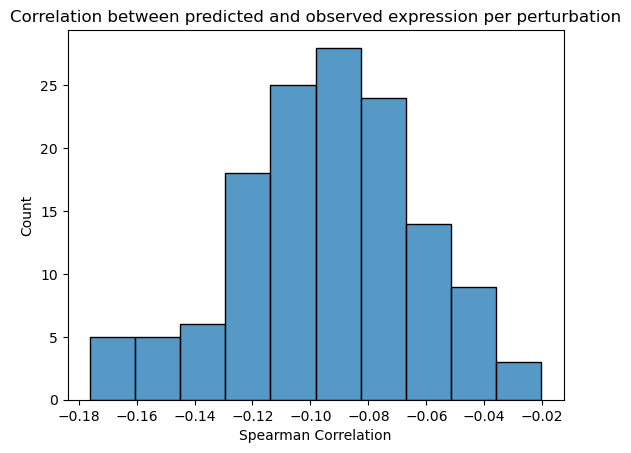

In [8]:
# plot train correlation distribution vs test correlation distribution
import seaborn as sns

test_corr = np.array(test_corr_singles + test_corr_combos)[:, 1].astype(float)
sns.histplot(test_corr, label="test_corr")
plt.title("Correlation between predicted and observed expression per perturbation")
plt.xlabel("Spearman Correlation")
plt.show()

In [95]:
np.savetxt(
    "figures/reconstruction_spearmans/GSFA_inhouse_spearman_correlations.csv",
    test_corr,
    delimiter=",",
    fmt="%.2f",
)

# Perturbation Embedding Heatmap

## Hierarchical Clustering + Enrichment
- Perform enrichment tests (gprofiler) on hierarchical clustering of perturbation embeddings

In [ ]:
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

# Put into df
pert_emb_df = pd.DataFrame(beta[:-1], index=pert_labels)
pert_emb_df = pert_emb_df.drop(columns=[0]).astype("float")

# Compute the pairwise distances
df = pert_emb_df.drop(index=["ctrl", "intergenic"])

distance = "euclidean"

distances = pdist(df.values, metric=distance)

# Convert the distances into a square distance matrix
distance_matrix = pd.DataFrame(squareform(distances), index=df.index, columns=df.index)
clustermap = sns.clustermap(distance_matrix, cmap="viridis_r")
clustermap.fig.suptitle(f"Pairwise {distance} distance of perturbation latent vectors")
# clustermap.ax_row_dendrogram.set_visible(False)
clustermap.ax_col_dendrogram.set_visible(False)
plt.show()

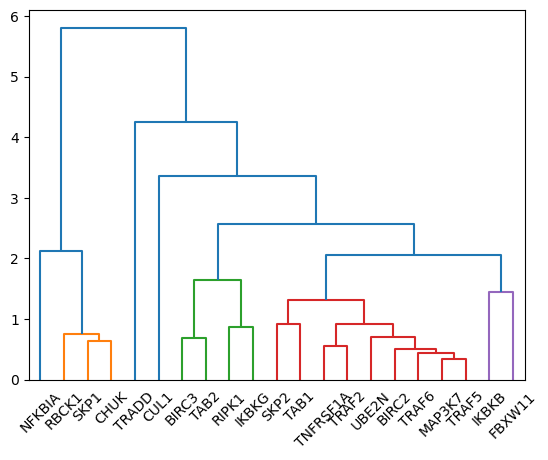

In [10]:
from scipy.cluster.hierarchy import dendrogram

den = dendrogram(
    clustermap.dendrogram_col.linkage, labels=distance_matrix.index, color_threshold=2
)

In [12]:
# extract clusters and perform gprofiler
from collections import defaultdict


def get_cluster_classes(den, label="ivl"):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den["color_list"], den["icoord"]):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    cluster_classes = {}
    for c, l in cluster_idxs.items():  # noqa
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    return cluster_classes


clusters = get_cluster_classes(den)
# extract functions for clusters
cluster_process = {}
for c in clusters:
    cluster_df = pd.DataFrame(clusters[c], columns=["gene_symbol"])
    res = get_gprofiler(cluster_df)
    cluster_process[c] = res[res["p_value"] <= 0.05]

In [266]:
# save grpofiler results
with open(
    "figures/pert_embedding_cluster_gprofiler/GSFA_inhouse_pert_emb_gprofiler.pickle",
    "wb",
) as handle:
    pickle.dump(cluster_process, handle, protocol=pickle.HIGHEST_PROTOCOL)

## PR Curve+AUC
- AUCPR using prior graph as binary label

In [268]:
aucpr_df, f1_df, pr_dict = auprc(distance_matrix)
print(aucpr_df)
print(f1_df)
aucpr_df.to_csv("figures/pert_embedding_recall/GSFA_inhouse_aucpr.csv")
f1_df.to_csv("figures/pert_embedding_recall/GSFA_inhouse_f1.csv")

               AUC
StringDB  0.685749
CORUM     0.536772
                F1  Threshold
StringDB  0.689548   0.011192
CORUM     0.632953   0.016780


# Interpretability of our learned latent space

## Factor Enrichment
- GSEA on log transformed latent-by-gene factors
- Then associate each perturbation to its top latent factors

In [ ]:
factor_to_go = factor_enrichment_gsea(adata, W.T, fdr=5e-2)

In [ ]:
# filter and add description to processes
go_df = read_aws_csv("s3://pert-spectra/references/GO_to_Description.txt")
go_df.set_index("Term", inplace=True)
go_dict = go_df.to_dict()["Description"]

filtered_factor_to_go = {}
for i in factor_to_go:
    proc = factor_to_go[i]
    proc["descr"] = [go_dict[x] for x in proc["GO_ID"]]
    filtered_factor_to_go[i] = proc

In [98]:
with open(
    "figures/factor_enrichments/GSFA_inhouse_factor_enrichment.pickle", "wb"
) as handle:
    pickle.dump(filtered_factor_to_go, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Overlap with prior knowledge/ground truth (stringdb)
- Group A: a set of GO terms associated with a perturbation (either drivers from msigdb, or from literature) and its neighbors in stringdb
- Group B: a set of GO terms from the interpretability analysis
- Hypergeometric test on the overlap of the two groups

In [14]:
# load precomputed factor_to_go dict if available
filtered_factor_to_go = read_aws_pickle(
    "s3://pert-spectra/figures/factor_enrichments/GSFA_inhouse_factor_enrichment.pickle"
)

In [17]:
# get neighbors for each perturbation
pert_neighbors = retrieve_stringdb_neighbors(pert_labels)

In [18]:
# construct group A - known processes for each perturbation
gene_sets = read_aws_pickle("s3://pert-spectra/references/GO_to_Gene.pickle")
# subset to biological processes
go_reference = read_aws_csv("s3://pert-spectra/references/GO_terms.txt.gz", zipped=True)
go_bp = go_reference[go_reference["go_category"] == "biological_process"]
go_bp_ids = set(go_bp["go_id"].values)
filtered_go_terms = {key: gene_sets[key] for key in go_bp_ids if key in gene_sets}

# GO terms per perturbation AND its neighbors in stringdb
pert_to_go = {key: set() for key in df.index}
for goterm in filtered_go_terms:
    for pert in df.index:
        if pert in filtered_go_terms[goterm] and set(
            filtered_go_terms[goterm]
        ).intersection(pert_neighbors[pert]):
            pert_to_go[pert].add(goterm)

In [19]:
# construct set B - model identified processes for each perturbation
n = 2  # number of top factors to get processes from
model_pert_to_go = {}
for pert in pert_emb_df.index:
    if pert in ["ctrl", "intergenic", "basal"]:
        continue
    # get top factors
    pert_emb_df = pd.DataFrame(beta[:-1], index=pert_labels)
    pert_loading = pert_emb_df.loc[pert].to_numpy()[1:].astype(float)
    ctrl_loading = pert_emb_df.loc["intergenic"].to_numpy()[1:].astype(float)
    delta_loading = np.abs(np.log(np.abs(pert_loading)) - np.log(np.abs(ctrl_loading)))
    top_n_factors = np.argpartition(np.array(delta_loading), -n)[-n:]
    # get processes
    model_processes = set()
    for f in top_n_factors:
        proc = filtered_factor_to_go[f]
        model_processes = model_processes.union(set(proc["Term"]))
    model_pert_to_go[pert] = model_processes

/tmp/ipykernel_32012/994851414.py:11: RuntimeWarning: divide by zero encountered in log
  delta_loading = np.abs(np.log(np.abs(pert_loading))-np.log(np.abs(ctrl_loading)))


In [20]:
pvals = perturbation_signal_recovery(
    pert_to_go,
    model_pert_to_go,
    list(filtered_go_terms.keys()),
    list(pert_emb_df.index),
)

Overlap for RIPK1: 9 out of 38 in researchDB
P-value for RIPK1: 1.1308619075120921e-07
Overlap for MAP3K7: 0 out of 23 in researchDB
P-value for MAP3K7: 1.0
Overlap for IKBKB: 7 out of 24 in researchDB
P-value for IKBKB: 3.830013304044622e-07
Overlap for SKP1: 0 out of 7 in researchDB
P-value for SKP1: 1.0
Overlap for BIRC3: 3 out of 20 in researchDB
P-value for BIRC3: 0.007686716976516679
Overlap for TAB2: 0 out of 5 in researchDB
P-value for TAB2: 1.0
Overlap for NFKBIA: 6 out of 28 in researchDB
P-value for NFKBIA: 1.8192895607157648e-05
Overlap for SKP2: 1 out of 6 in researchDB
P-value for SKP2: 0.11702982854059442
Overlap for TRAF6: 4 out of 46 in researchDB
P-value for TRAF6: 0.018440536255468803
Overlap for FBXW11: 5 out of 13 in researchDB
P-value for FBXW11: 3.4478778936666224e-06
Overlap for TRAF5: 4 out of 14 in researchDB
P-value for TRAF5: 0.00020482544648502187
Overlap for CHUK: 7 out of 21 in researchDB
P-value for CHUK: 1.84359744108617e-07
Overlap for RBCK1: 0 out of 

In [262]:
# save as csv for visualization
pd.DataFrame.from_dict(data=pvals, orient="index").to_csv(
    "figures/process_recovery_hypergeo_pvals/GSFA_inhouse_hypergeo_neighbors_recovery_pvalues.csv",
    header=False,
)